# Data exploration

## Import dataset

In [41]:
import pandas as pd
import os

df = pd.DataFrame()
directory_path = "data/"
for file_name in os.listdir(directory_path):
    try:
        file_path = os.path.join(directory_path, file_name)
        # Read the CSV file into a temporary DataFrame
        temp_df = pd.read_excel(file_path, )
        
        # Append the contents to the main DataFrame
        df = pd.concat([df, temp_df], ignore_index=True)
    except:
        print(f"Cannot append {file_name} in the dataframe")

df.head()

Cannot append cleaned_data.csv in the dataframe


,note,auteur,avis,assureur,produit,type,date_publication,date_exp,avis_en,avis_cor,avis_cor_en
0,3.0,acacia-69753,"Bonjour, j'ai été démarché au téléphone, la pe...",Néoliane Santé,sante,train,29/12/2018,01/12/2018,"Hello, I was approached on the phone, the pers...",NaN,NaN
1,4.0,gelas-m-119083,Je suis satisfait du service et des tarifs pro...,L'olivier Assurance,auto,train,24/06/2021,01/06/2021,I am satisfied with the service and the prices...,NaN,NaN
2,1.0,mathilde-112565,on m a oblige a adherer a un pack en me disant...,Harmonie Mutuelle,sante,train,04/05/2021,01/05/2021,I was forced to adhere to a pack telling me th...,NaN,NaN
3,2.0,mau56-81436,Sociétaire MACIF depuis 1972 bonus à 50 et 4 c...,MACIF,auto,train,02/12/2019,01/12/2019,Macif member since 1972 bonuses at 50 and 4 co...,NaN,NaN
4,5.0,ely-103247,Je suis à la MAIF depuis plus 40 ans et en sui...,MAIF,auto,train,26/01/2021,01/01/2021,I have been in Maif for over 40 years and am v...,NaN,NaN


In [42]:
# Drop useless columns 
df.drop(["auteur","avis_cor_en","avis_cor"], axis=1, inplace= True)

# Aesthetic
df['produit']= df['produit'].str.capitalize()

In [43]:
# Convert a column to datetime
df['date_publication'] = pd.to_datetime(df['date_publication'], dayfirst=True)
df['date_exp'] = pd.to_datetime(df['date_exp'], dayfirst=True)
df['produit'] = df['produit'].astype('category')
df['assureur'] = df['assureur'].astype('category')
df['type'] = df['type'].astype('category')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34435 entries, 0 to 34434
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   note              24104 non-null  float64       
 1   avis              34435 non-null  object        
 2   assureur          34435 non-null  category      
 3   produit           34435 non-null  category      
 4   type              34435 non-null  category      
 5   date_publication  34435 non-null  datetime64[ns]
 6   date_exp          34435 non-null  datetime64[ns]
 7   avis_en           34433 non-null  object        
dtypes: category(3), datetime64[ns](2), float64(1), object(2)
memory usage: 1.4+ MB


In [45]:
df

,note,avis,assureur,produit,type,date_publication,date_exp,avis_en
0,3.0,"Bonjour, j'ai été démarché au téléphone, la pe...",Néoliane Santé,Sante,train,2018-12-29,2018-12-01,"Hello, I was approached on the phone, the pers..."
1,4.0,Je suis satisfait du service et des tarifs pro...,L'olivier Assurance,Auto,train,2021-06-24,2021-06-01,I am satisfied with the service and the prices...
2,1.0,on m a oblige a adherer a un pack en me disant...,Harmonie Mutuelle,Sante,train,2021-05-04,2021-05-01,I was forced to adhere to a pack telling me th...
3,2.0,Sociétaire MACIF depuis 1972 bonus à 50 et 4 c...,MACIF,Auto,train,2019-12-02,2019-12-01,Macif member since 1972 bonuses at 50 and 4 co...
4,5.0,Je suis à la MAIF depuis plus 40 ans et en sui...,MAIF,Auto,train,2021-01-26,2021-01-01,I have been in Maif for over 40 years and am v...
...,...,...,...,...,...,...,...,...
34430,5.0,"Facilité pour contracter via internet, prix tr...",AMV,Moto,train,2021-01-12,2021-01-01,"Easy to contract via the Internet, very compet..."
34431,4.0,Je suis satisfait du service: j'ai eu à contac...,GMF,Auto,train,2021-07-18,2021-07-01,I am satisfied with the service: I had to cont...
34432,1.0,Bonjour \nJe suis en arrêt depuis plus de troi...,Allianz,Prevoyance,train,2020-07-21,2020-07-01,Hello\nI have stopped for more than three mont...
34433,1.0,Suite à un dégât des eaux j’attends depuis plu...,Matmut,Habitation,train,2021-04-22,2021-04-01,Following a water damage I have been waiting f...


## Data visualization

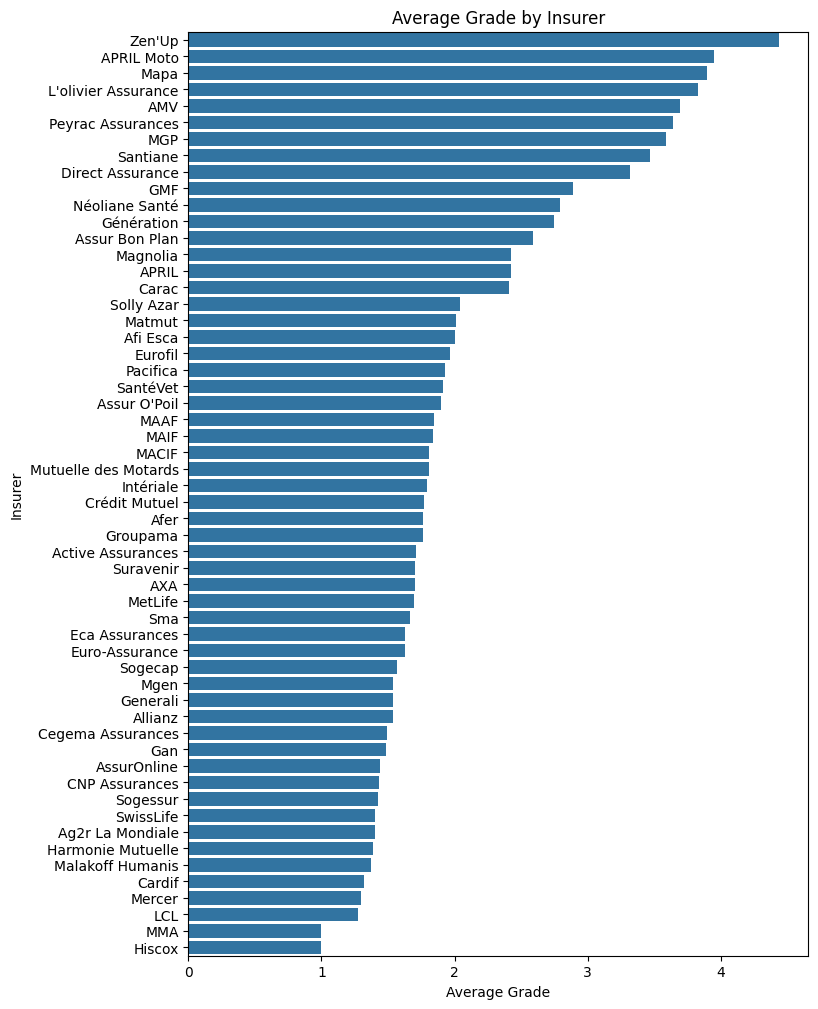

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'assureur' and calculate the mean of 'note'
average_grade_by_insurer = df.groupby('assureur', observed=True)['note'].mean().reset_index()

# Sort the data by the average grade for better visualization
average_grade_by_insurer = average_grade_by_insurer.sort_values(by='note', ascending=False)

# Plotting using seaborn
plt.figure(figsize=(8,12))
sns.barplot(x='note', y='assureur', data=average_grade_by_insurer, order=average_grade_by_insurer['assureur'])
plt.title('Average Grade by Insurer')
plt.xlabel('Average Grade')
plt.ylabel('Insurer')
plt.show()

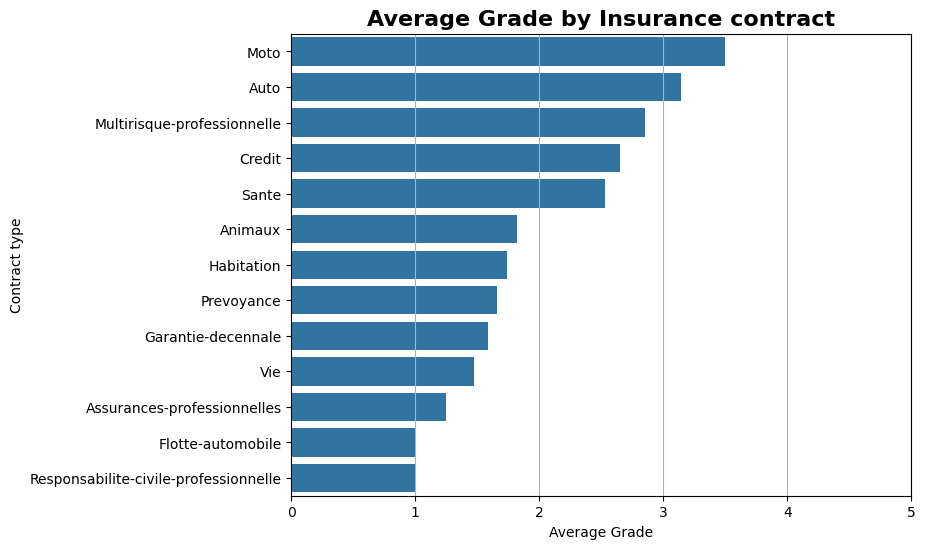

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'assureur' and calculate the mean of 'note'
average_grade_by_insurer = df.groupby('produit', observed=True)['note'].mean().reset_index()

# Sort the data by the average grade for better visualization
average_grade_by_insurer = average_grade_by_insurer.sort_values(by='note', ascending=False)

# Plotting using seaborn
plt.figure(figsize=(8,6))
sns.barplot(x='note', y='produit', data=average_grade_by_insurer, order=average_grade_by_insurer['produit'])
plt.title('Average Grade by Insurance contract',fontsize=16, fontweight='bold')
plt.xlabel('Average Grade')
plt.xlim((0,5))
plt.grid(axis = "x")
plt.ylabel('Contract type')
plt.show()

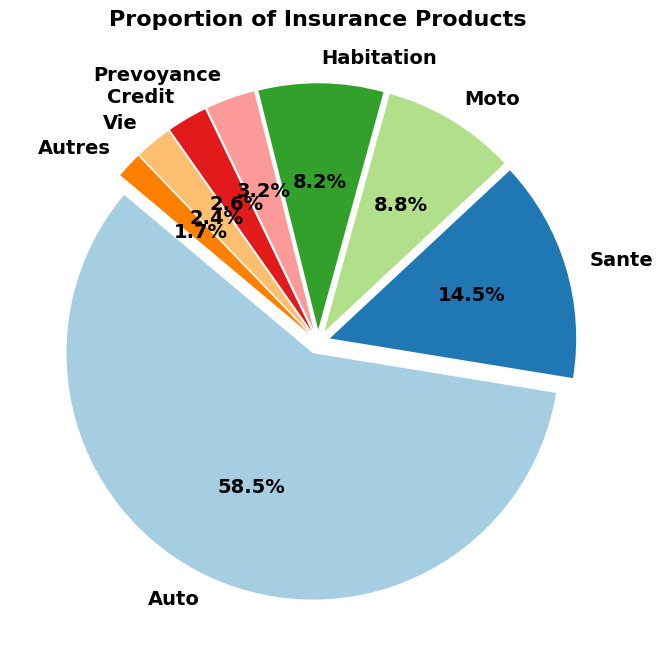

In [48]:
# Calculate the count and proportion of each product
product_counts = df['produit'].value_counts()
product_proportions = product_counts / product_counts.sum() * 100

# Categorize products with less than 2% as 'Autre'
product_proportions['Autres'] = product_proportions[product_proportions < 2].sum()

# Filter out products that have less than 2% and create a new Series
filtered_product_proportions = product_proportions[product_proportions >= 2]

# Combine the 'autres' category
final_product_proportions = pd.concat([filtered_product_proportions, pd.Series({'Autres': product_proportions['Autres']})])

# Plot the pie chart
plt.figure(figsize=(10, 8))
plt.pie(final_product_proportions, labels=final_product_proportions.index,
        textprops={'weight': 'bold', 'size': 14},
          autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors,explode=[0.05 for _ in range(len(final_product_proportions))])
plt.title('Proportion of Insurance Products',fontsize=16, fontweight='bold')
plt.show()

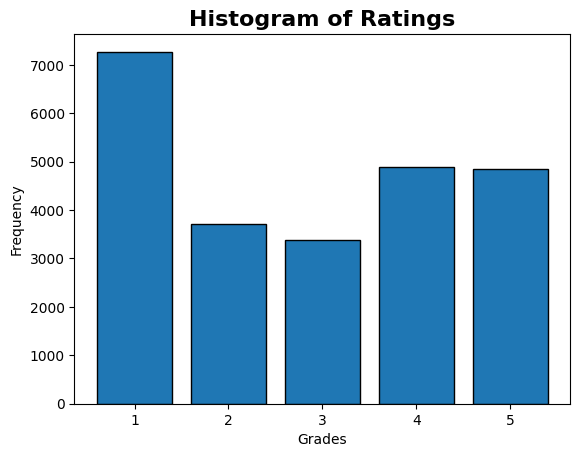

In [50]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(df['note'], bins=range(1, 7), edgecolor='black', align='left', rwidth=0.8)
plt.xlabel('Grades')
plt.ylabel('Frequency')
plt.title('Histogram of Ratings',fontsize=16, fontweight='bold')
plt.xticks(range(1, 6))  # Ensure labels match discrete categories
plt.show()

## Initial conclusions

s

## Export the cleaned dataset

In [52]:
df.to_csv("data/cleaned_data.csv")